In [1]:
from sklearn.feature_selection import mutual_info_regression
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd
import numpy as np

plt.rcParams['figure.dpi'] = 300
sns.set_theme(font_scale = 0.75)
sns.set_style('whitegrid')

plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout = True)
plt.rc(
    "axes",
    labelweight = "bold",
    labelsize = "large",
    titleweight = "bold",
    titlesize = 14,
    titlepad = 10,
)


def plot_variance(pca, width = 8, dpi = 300):
    # create figure
    fig, axs = plt.subplots(1, 2)
    n = pca.n_components_
    grid = np.arange(1, n + 1)
    
    # explained variance
    evr = pca.explained_variance_ratio_
    axs[0].bar(grid, evr)
    axs[0].set(
        xlabel="Component", title="% Explained Variance", ylim=(0.0, 1.0)
    )
    
    # cumulative Variance
    cv = np.cumsum(evr)
    axs[1].plot(np.r_[0, grid], np.r_[0, cv], "o-")
    axs[1].set(
        xlabel="Component", title="% Cumulative Variance", ylim=(0.0, 1.0)
    )
    
    # set up figure
    fig.set(figwidth=8, dpi=100)
    return axs


def make_mi_scores(X, y, discrete_features):
    mi_scores = mutual_info_regression(X, y, discrete_features = discrete_features)
    mi_scores = pd.Series(mi_scores, name = 'mi_scores', index = X.columns)
    mi_scores = mi_scores.sort_values(ascending = False)
    return mi_scores


df = pd.read_csv('./data/autos.csv')

In [2]:
features = ['highway_mpg', 'engine_size', 'horsepower', 'curb_weight']

X = df.copy()

y = X.pop('price')
X = X[features]

X_scaled = (X - X.mean(axis = 0)) / X.std(axis = 0)

In [3]:
pca = PCA()
X_pca = pca.fit_transform(X_scaled)

component_names = [f"PC{i + 1}" for i in range(X_pca.shape[1])]
X_pca = pd.DataFrame(X_pca, columns = component_names)

X_pca.head(10)

,PC1,PC2,PC3,PC4
0,0.382486,-0.400222,0.124122,0.169539
1,0.382486,-0.400222,0.124122,0.169539
2,1.550890,-0.107175,0.598361,-0.256081
3,-0.408859,-0.425947,0.243335,0.013920
4,1.132749,-0.814565,-0.202885,0.224138
5,0.547265,-0.545141,0.139969,0.424955
6,0.869268,-0.472834,-0.294073,0.090174
7,0.974373,-0.449233,-0.435749,-0.019102
8,1.796553,-1.050783,-0.081821,-0.296071
9,-0.306514,-0.542020,0.138605,0.012612


In [7]:
pca.components_

array([[-0.4923469 ,  0.50385865,  0.50044809,  0.50326205],
       [ 0.77089183,  0.62670948,  0.01378838,  0.11300841],
       [ 0.07014167,  0.01996004,  0.73109336, -0.67836881],
       [-0.39799556,  0.59410713, -0.46353435, -0.52323242]])

In [8]:
loadings = pd.DataFrame(
    pca.components_.T,
    columns = component_names,
    index = X.columns,
)

loadings

,PC1,PC2,PC3,PC4
highway_mpg,-0.492347,0.770892,0.070142,-0.397996
engine_size,0.503859,0.626709,0.019960,0.594107
horsepower,0.500448,0.013788,0.731093,-0.463534
curb_weight,0.503262,0.113008,-0.678369,-0.523232


array([<AxesSubplot:title={'center':'% Explained Variance'}, xlabel='Component'>,
       <AxesSubplot:title={'center':'% Cumulative Variance'}, xlabel='Component'>],
      dtype=object)

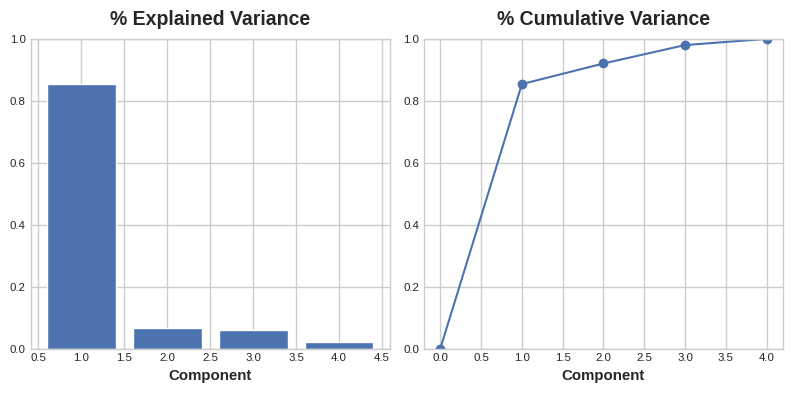

In [9]:
plot_variance(pca)

In [10]:
mi_scores = make_mi_scores(X_pca, y, discrete_features = False)
mi_scores

PC1    1.013450
PC2    0.379122
PC3    0.307113
PC4    0.204192
Name: mi_scores, dtype: float64

In [11]:
idx = X_pca['PC3'].sort_values(ascending = False).index
cols = ['make', 'body_style', 'horsepower', 'curb_weight']

df.loc[idx, cols]

,make,body_style,horsepower,curb_weight
117,porsche,hardtop,207,2756
118,porsche,hardtop,207,2756
119,porsche,convertible,207,2800
45,jaguar,sedan,262,3950
96,nissan,hatchback,200,3139
...,...,...,...,...
59,mercedes-benz,wagon,123,3750
61,mercedes-benz,sedan,123,3770
101,peugot,wagon,95,3430
105,peugot,wagon,95,3485


<AxesSubplot:xlabel='sports_or_wagon', ylabel='price'>

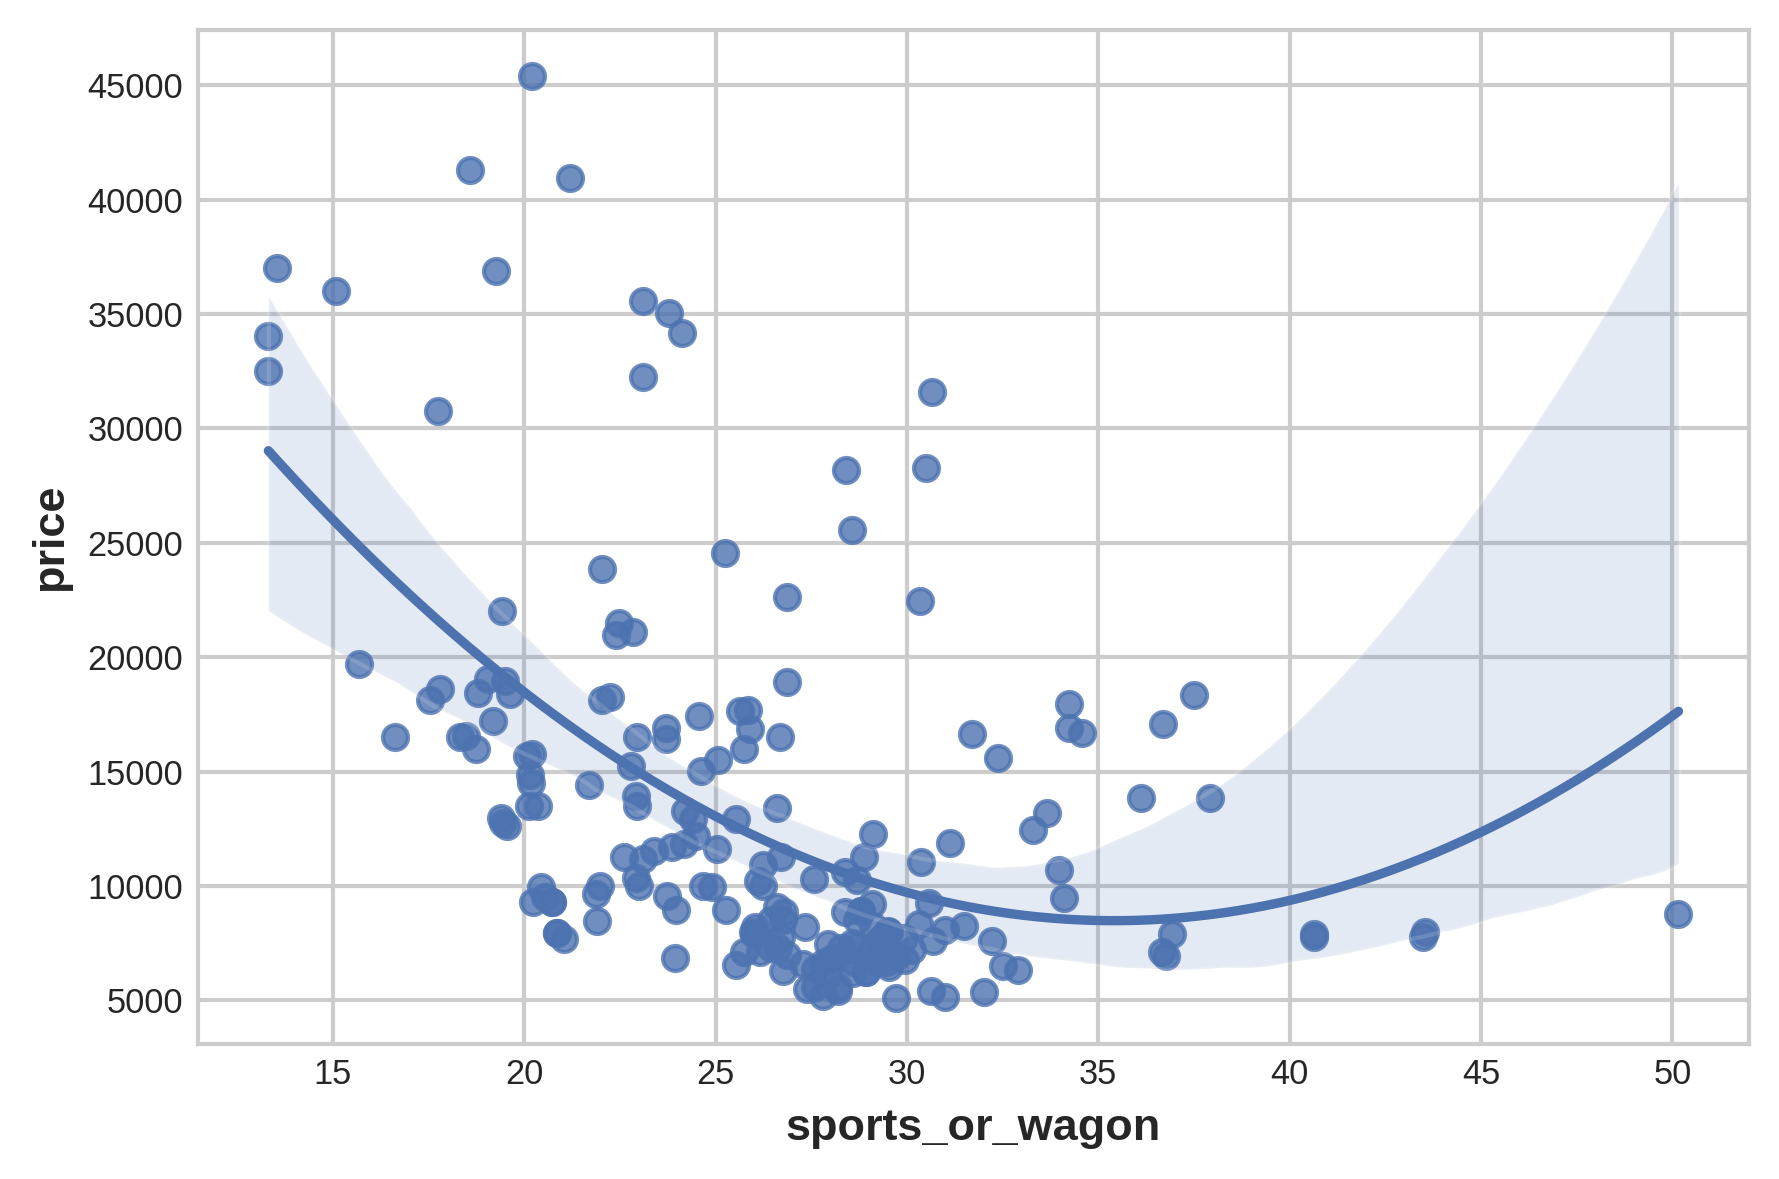

In [14]:
df['sports_or_wagon'] = X.curb_weight / X.horsepower

sns.regplot(data = df,
            x = 'sports_or_wagon', y = 'price',
            order = 2, ci = 99)

In [17]:
from sklearn.model_selection import cross_val_score
from xgboost import XGBRegressor

def apply_pca(X, standardize = True):
    if standardize:
        X = (X - X.mean(axis = 0)) / X.std(axis = 0)
        
    pca = PCA()
    X_pca = pca.fit_transform(X)
    
    component_names = [f'PC{i + 1}' for i in range(X_pca.shape[1])]
    X_pca = pd.DataFrame(X_pca, columns = component_names)
    
    loadings = pd.DataFrame(
        pca.components_.T,
        columns = component_names,
        index = X.columns,
    )
    
    return pca, X_pca, loadings


def score_dataset(X, y, model = XGBRegressor()):
    for colname in X.select_dtypes(['category', 'object']):
        X[colname], _ = X[colname].factorize()
        
    score = cross_val_score(
        model, X, y, cv = 5, scoring = 'neg_mean_squared_log_error',
    )
    
    score = -1 * score.mean()
    score = np.sqrt(score)
    
    return score


df = pd.read_csv('./data/ames.csv')

In [18]:
features = [
    'GarageArea',
    'YearRemodAdd',
    'TotalBsmtSF',
    'GrLivArea',
]

print("Correlation with SalePrice:\n")
print(df[features].corrwith(df.SalePrice))

Correlation with SalePrice:

GarageArea      0.640138
YearRemodAdd    0.532974
TotalBsmtSF     0.632529
GrLivArea       0.706780
dtype: float64


In [19]:
X = df.copy()

y = X.pop('SalePrice')
X = X[features]

pca, X_pca, loadings = apply_pca(X)
loadings

,PC1,PC2,PC3,PC4
GarageArea,0.541229,0.102375,-0.038470,0.833733
YearRemodAdd,0.427077,-0.886612,-0.049062,-0.170639
TotalBsmtSF,0.510076,0.360778,-0.666836,-0.406192
GrLivArea,0.514294,0.270700,0.742592,-0.332837


In [21]:
make_mi_scores(X_pca, y, discrete_features = False)

PC1    0.872679
PC3    0.341724
PC2    0.263145
PC4    0.088010
Name: mi_scores, dtype: float64

In [22]:
X = df.copy()

y = X.pop('SalePrice')
X = X.join(X_pca.loc[:, ['PC1', 'PC3']])

score = score_dataset(X, y)
score

0.1381905717889875

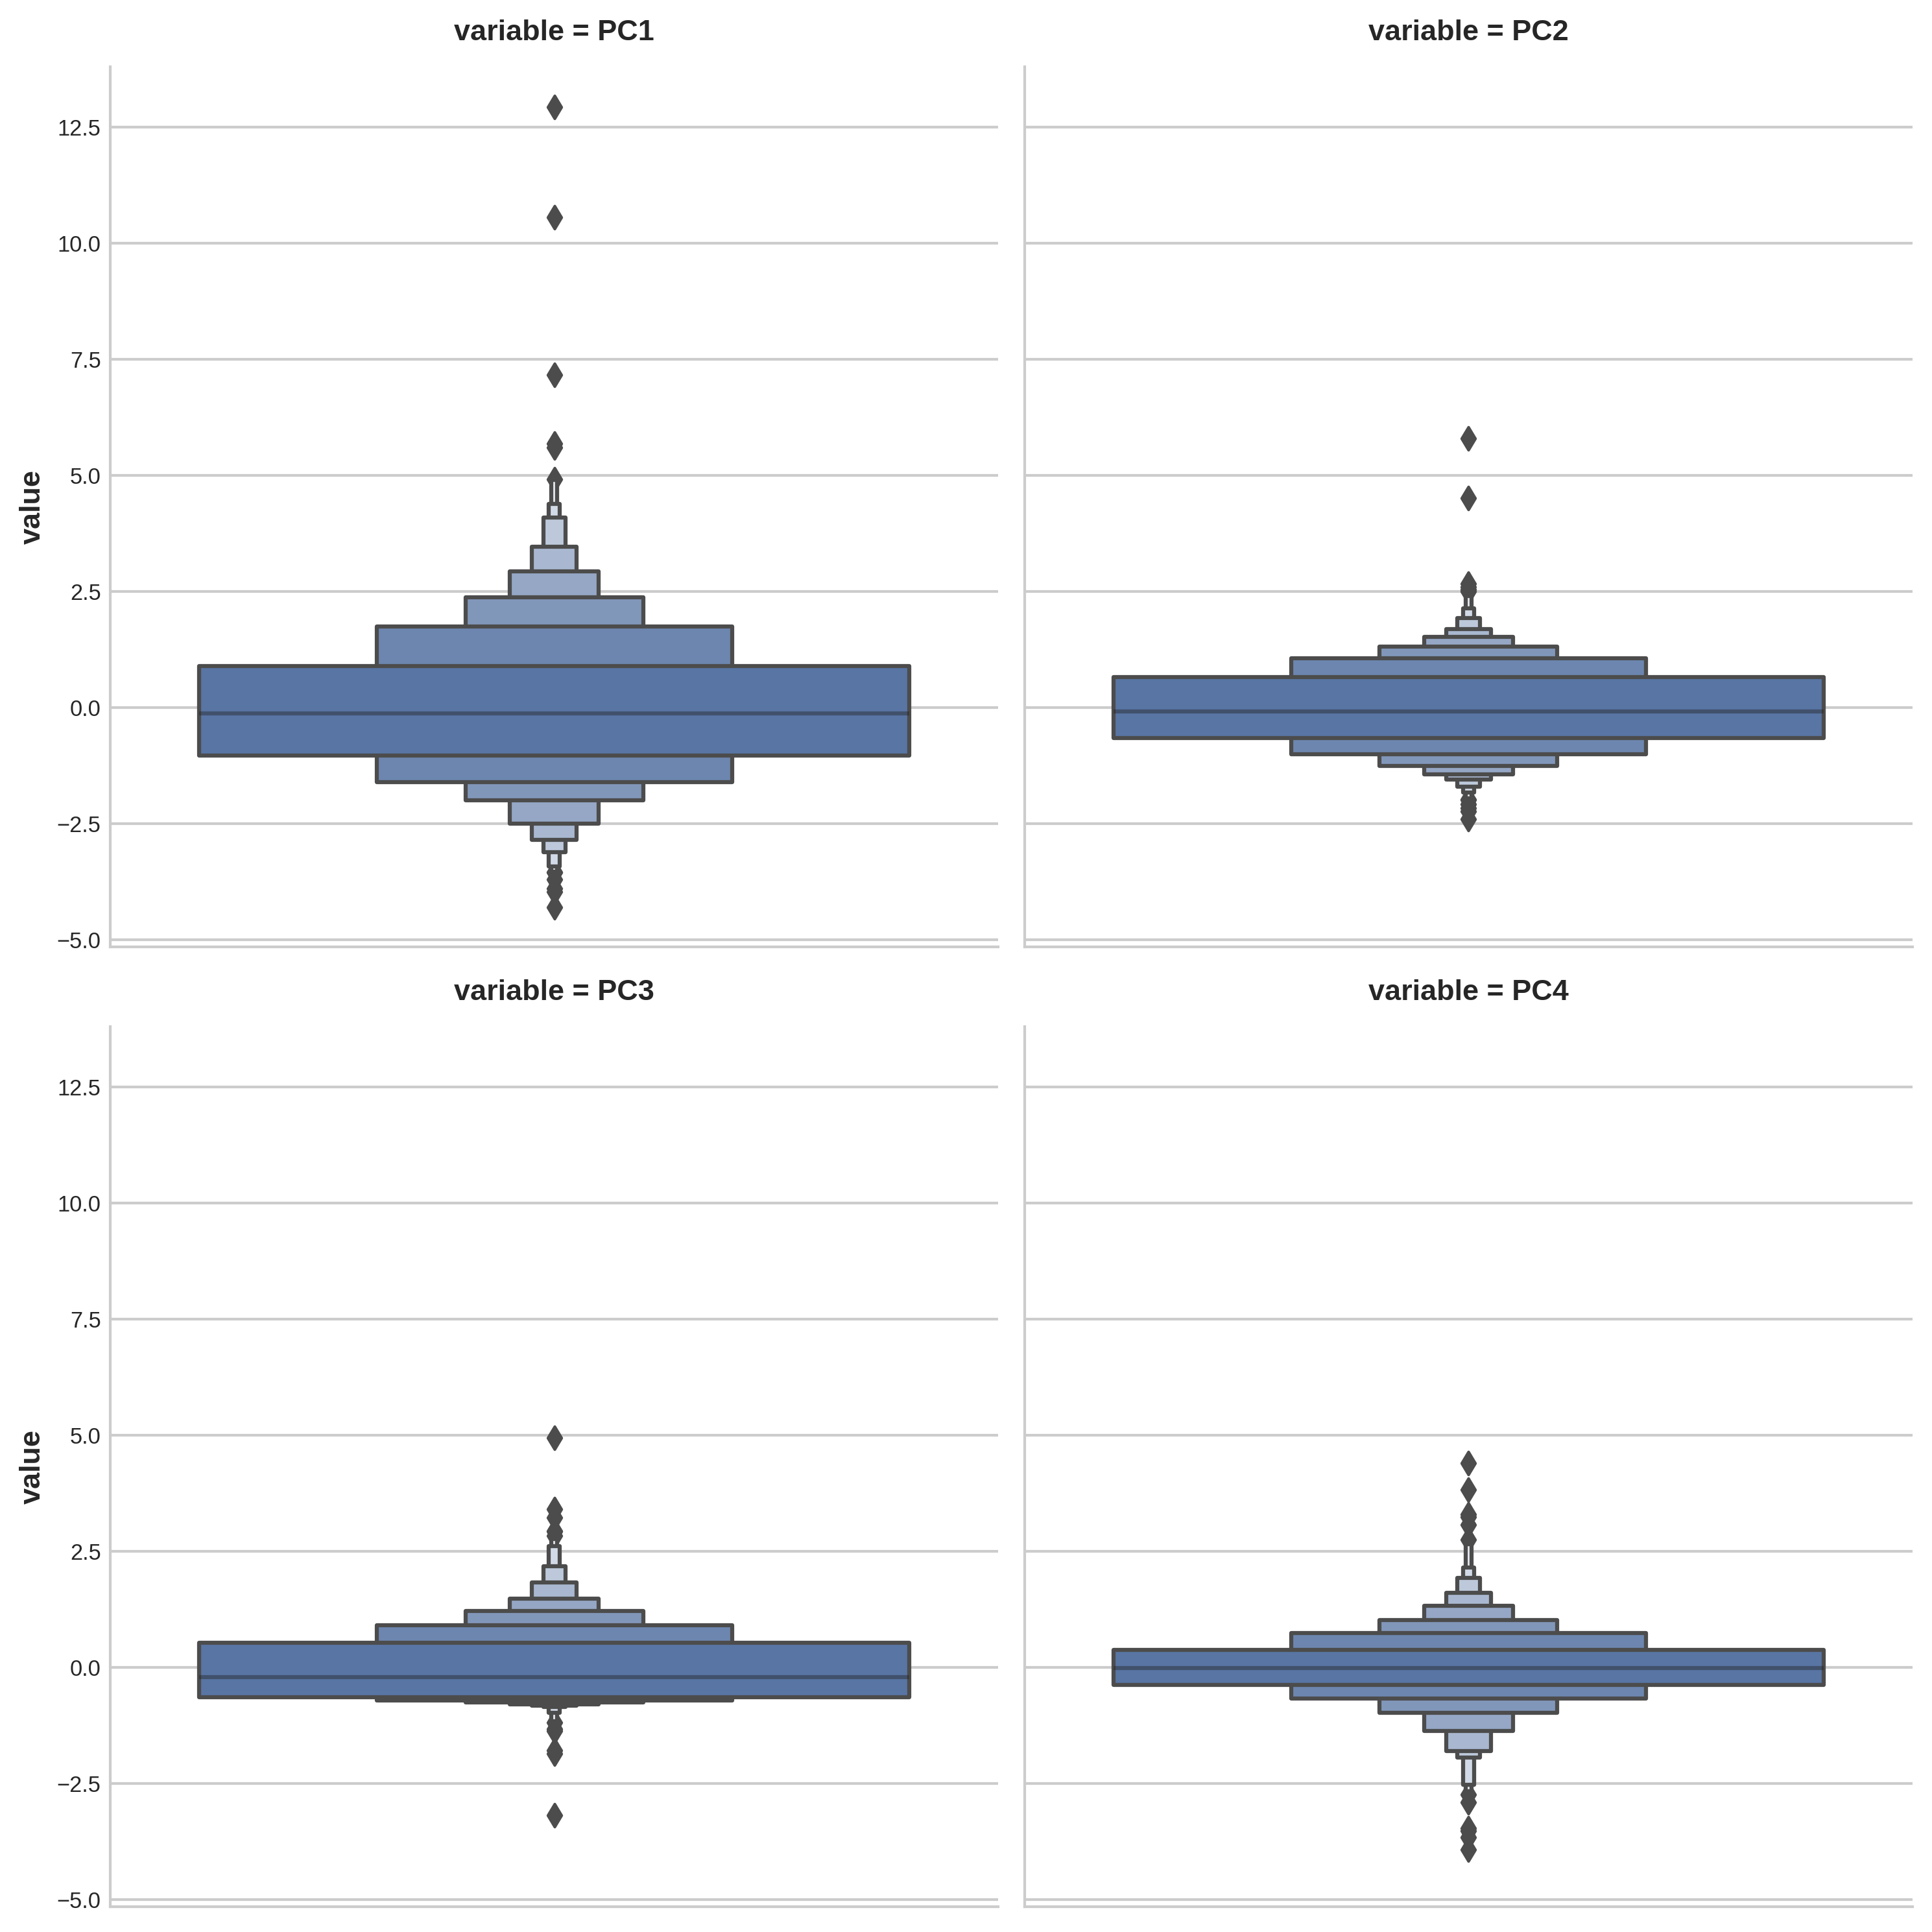

In [24]:
sns.catplot(
    data = X_pca.melt(), kind = 'boxen',
    y = 'value', col = 'variable', sharey = True, col_wrap = 2,    
)

In [26]:
component = 'PC1'

idx = X_pca[component].sort_values(ascending = False).index
df.loc[idx, ['SalePrice', 'Neighborhood', 'SaleCondition'] + features]

,SalePrice,Neighborhood,SaleCondition,GarageArea,YearRemodAdd,TotalBsmtSF,GrLivArea
1498,160000,Edwards,Partial,1418.0,2008,6110.0,5642.0
2180,183850,Edwards,Partial,1154.0,2009,5095.0,5095.0
2181,184750,Edwards,Partial,884.0,2008,3138.0,4676.0
1760,745000,Northridge,Abnorml,813.0,1996,2396.0,4476.0
1767,755000,Northridge,Normal,832.0,1995,2444.0,4316.0
...,...,...,...,...,...,...,...
662,59000,Old_Town,Normal,0.0,1950,416.0,599.0
2679,80500,Brookside,Normal,0.0,1950,0.0,912.0
2879,51689,Iowa_DOT_and_Rail_Road,Abnorml,0.0,1950,0.0,729.0
780,63900,Sawyer,Normal,0.0,1950,0.0,660.0
